<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>"Глубокое обучение". Продвинутый поток</b></h3>

<h2 style="text-align: center;"><b>Семинар 6. PyTorch. Создание и обучение нейронных сетей </b></h2>


# Neural networks training using PyTorch

In this notebook we build and train simple neural network using PyTorch. Our goal is to show the basics of torch framework and achieve simple understandings of how problemsolving with neural networks looks like.

In [1]:
import torch

In [2]:
device = torch.device('cuda:0') if torch.cuda.is_available else torch.device('cpu')
device

device(type='cuda', index=0)

## Dataset Preparation

Here we learn some basic data preparation functions and classes from PyTorch as:

- `torch.utils.data.Dataset` and `torch.utils.data.DataLoader`
- dataset downloading api

First we would like to define our problem. Here we load the MNIST dataset (with PyTorch API)

MNIST:
- 28x28 images of `0`, `1`, .. `9`
- each pixel is grayscaled (float value in [0, 1))
- targets are int values in [0, 9] (10 classes)
- objects are ($x_i$, $y_i$), where $x_i$ shape is (1, 28, 28), $y_i$ is int value

For our purposes we will flatten the input ($x$), so our data during train will have shapes:

- `x_batch` shape `(batch_size, 784)`
- `y_batch` shape `(batch_size)`



In [3]:
from torchvision.datasets import MNIST
import torchvision.transforms as tfs

In [4]:
data_tfs = tfs.Compose([
  tfs.ToTensor(),
  tfs.Normalize((0.5), (0.5))
])

In [7]:
# install for train and test
root = './'
train = MNIST(root, train=True,  transform=data_tfs, download=True)
test  = MNIST(root, train=False, transform=data_tfs, download=True)

In [8]:
print(f'Data size:\n\t train {len(train)},\n\t test {len(test)}')
print(f'Data shape:\n\t features {train[0][0].shape},\n\t target {type(test[0][1])}')

Data size:
	 train 60000,
	 test 10000
Data shape:
	 features torch.Size([1, 28, 28]),
	 target <class 'int'>


New thing we don't need to make batch loader by ourselves. Let us use the torch implementation of it called `DataLoader` from `torch.utils.data`

In [9]:
from torch.utils.data import DataLoader

batch_size = 128

train_loader = DataLoader(train, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, drop_last=True)

In [32]:
x_batch, y_batch = next(iter(train_loader))
x_batch.shape, y_batch.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

Finally we're prepared our data, so let's build some model to classify the images!

## Model and Train (of abnormal people)

We now how the torch computes the gradient functions during the computation of expression. Using `.backward()` method on expression **we pass the tree of gradient computing till the leafs** which are reliable for parameters of our model.

Thus, we use this knowledge to find the optimal weights of some model, which is represented by some expression.

Assume,
1. We want to learn linear model
2. For each class we use own weights to calculate logits
3. We use softmax on logits for probabilities of each class
4. Train on batches using sgd

In [11]:
features = 784
classes = 10

In [12]:
W = torch.FloatTensor(features, classes).uniform_(-1, 1) / features**0.5
W.requires_grad_()

tensor([[-0.0134, -0.0228, -0.0029,  ..., -0.0303, -0.0195,  0.0227],
        [-0.0317, -0.0230, -0.0180,  ...,  0.0352, -0.0052,  0.0135],
        [-0.0132, -0.0249,  0.0184,  ..., -0.0037,  0.0210, -0.0236],
        ...,
        [ 0.0163, -0.0131, -0.0330,  ...,  0.0102, -0.0315,  0.0117],
        [ 0.0313,  0.0251,  0.0322,  ..., -0.0185, -0.0303, -0.0038],
        [ 0.0011,  0.0138,  0.0262,  ...,  0.0331, -0.0062, -0.0270]],
       requires_grad=True)

SGD train loop

In [13]:
epochs = 3
lr=1e-2
history = []

In [14]:
import numpy as np
from torch.nn.functional import cross_entropy

In [31]:
x_batch.reshape(x_batch.shape[0], -1)

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]], device='cuda:0')

In [35]:
x_batch.shape

torch.Size([128, 1, 28, 28])

In [16]:
for i in range(epochs):
  for x_batch, y_batch in train_loader:
    # load batches of data correctly
    x_batch = x_batch.reshape(x_batch.shape[0], -1)

    # compute loss (log loss a.k.a. cross entropy)
    logits = x_batch @ W
    print(logits)
    probabilities = torch.exp(logits) / torch.exp(logits).sum(dim=1, keepdims=True)
    
    
    loss = -torch.log(probabilities[range(batch_size), y_batch]).mean()
    history.append(loss.item())

    # calc gradients
    loss.backward()

    # step of gradient descent
    grad = W.grad
    with torch.no_grad():
      W -= lr * grad
    W.grad.zero_()

  print(f'{i+1},\t loss: {history[-1]}')

tensor([[ 4.1894e-01, -2.0358e+00, -1.1718e-03,  ...,  1.0577e+00,
          1.1846e-01, -3.6890e-01],
        [ 8.6975e+00, -4.0924e+00, -4.3159e-01,  ...,  2.5141e-02,
         -2.0432e-01, -9.7858e-01],
        [-1.3502e+00, -1.7705e+00, -1.4111e-01,  ...,  1.5772e-01,
         -7.3178e-01,  1.6422e+00],
        ...,
        [-6.6661e-01,  1.2218e+00,  7.5900e-01,  ..., -2.6110e+00,
          4.8449e+00, -5.9450e-01],
        [-2.3123e-01, -3.6791e+00,  3.0948e+00,  ..., -4.6602e+00,
          1.9876e+00, -1.1358e+00],
        [-1.0944e+00, -2.1741e+00,  1.6642e-01,  ..., -8.4319e-02,
          8.2380e-01,  1.5969e-01]], grad_fn=<MmBackward>)
tensor([[-5.0452,  5.9941,  0.9125,  ..., -0.9524,  2.5364,  0.0118],
        [-1.3146, -0.5626,  0.8943,  ..., -5.4285,  3.5625, -0.0716],
        [-1.9906,  0.3937,  0.3418,  ...,  0.9337,  0.9065,  0.4332],
        ...,
        [ 0.6239, -2.8912,  7.6291,  ..., -4.6039,  0.2260, -3.7525],
        [ 1.3000, -0.5092, -1.0450,  ..., -1.8800,  0

tensor([[-4.4934,  4.8506,  1.4847,  ..., -0.6696,  0.7727, -0.4176],
        [ 0.8548, -3.2596, -1.6016,  ...,  6.4029, -0.5157,  4.1135],
        [-3.6085, -0.3303, -2.5530,  ...,  2.0280,  1.2833,  4.9347],
        ...,
        [ 7.5535, -4.6310, -0.5794,  ..., -1.0415, -2.3219, -1.2223],
        [-0.1113, -1.2941, -1.3663,  ...,  6.4657, -2.2169,  0.3765],
        [-1.4713, -1.1450, -0.5808,  ...,  0.2874,  3.1947,  3.3459]],
       grad_fn=<MmBackward>)
tensor([[-2.7804, -4.5610, -2.5826,  ...,  0.8460,  2.3076,  4.3239],
        [ 7.8452, -3.7899, -1.9065,  ..., -2.2844,  1.4904, -2.6056],
        [-3.2704, -2.9720, -2.2971,  ...,  2.2661, -0.1254,  6.1457],
        ...,
        [ 0.1127, -3.2356,  0.8531,  ..., -3.0796,  8.1518,  0.1532],
        [-2.6813, -3.2999, -0.7498,  ...,  2.1018,  0.5859,  1.9623],
        [-1.0581, -2.0642,  1.5721,  ..., -2.7476,  5.1790, -0.0748]],
       grad_fn=<MmBackward>)
tensor([[-2.9047,  4.8394, -0.2715,  ..., -0.1408,  0.8014, -0.4682],
    

tensor([[-0.8529, -0.8153, -0.0592,  ..., -1.1167,  1.0900, -1.1673],
        [-2.5490, -5.2398,  0.9316,  ...,  0.3352, -0.3797,  4.2620],
        [ 5.9597, -2.7288, -1.9714,  ...,  1.9697,  0.1769,  1.0308],
        ...,
        [-3.9290,  5.9082,  0.1113,  ..., -0.4948,  1.3097, -0.3675],
        [ 0.1312, -4.4656,  0.8270,  ...,  0.0827,  4.9765,  0.9773],
        [ 3.4873, -3.4729, -2.6270,  ...,  6.0698, -1.6794,  3.0353]],
       grad_fn=<MmBackward>)
tensor([[-5.1008, -2.8669,  2.9482,  ...,  1.0834,  2.6645,  3.1379],
        [-5.2357,  5.2872,  0.4910,  ..., -0.5724,  2.6203, -0.0877],
        [-4.0082, -1.8762,  0.1131,  ...,  5.5781, -0.5077,  3.7853],
        ...,
        [ 0.3940, -2.9909,  0.1600,  ...,  3.8267,  2.3921,  5.7855],
        [-0.0957, -0.9979,  1.6203,  ..., -2.8277,  1.4148, -0.5206],
        [ 0.1921, -2.8207, -0.3693,  ...,  6.3717, -1.1548,  4.0824]],
       grad_fn=<MmBackward>)
tensor([[-1.5595, -0.4359,  0.5573,  ..., -0.8021,  3.4986,  1.0572],
    

tensor([[-3.1576,  6.2248,  0.9133,  ..., -0.6260,  1.4756, -1.1254],
        [-0.6450, -1.3130,  5.9236,  ..., -0.6577,  0.4949, -0.4921],
        [-0.7523, -2.2475,  0.4651,  ..., -1.0936,  4.7920,  0.5518],
        ...,
        [ 1.0810, -1.1472, -1.9611,  ..., -1.3525,  0.2602,  0.8864],
        [-3.2850, -2.1065, -0.1896,  ...,  0.3589, -1.6342,  2.1262],
        [ 1.7370, -4.2071, -2.8526,  ...,  7.9033, -0.5393,  2.8191]],
       grad_fn=<MmBackward>)
tensor([[ 2.2702, -4.9170,  1.9608,  ..., -5.8456,  2.0389, -0.8447],
        [-2.4567,  5.6477,  1.9874,  ..., -0.6305,  1.1043, -1.7818],
        [-5.3985, -1.5922,  5.7811,  ..., -2.1201,  1.8350,  1.9070],
        ...,
        [ 0.1023,  0.1728, -0.3213,  ..., -1.2797,  0.7924, -0.8094],
        [-0.2200, -3.4508, -0.2926,  ..., -3.1314,  1.4832, -0.7825],
        [-0.8019, -0.2806, -0.4865,  ..., -0.0410,  0.2091,  2.5604]],
       grad_fn=<MmBackward>)
tensor([[-2.6911, -3.1929, -0.8680,  ...,  1.4139,  1.1756,  2.5012],
    

tensor([[-2.2692,  1.9466, -0.5224,  ..., -3.7395,  0.4139,  2.0875],
        [10.4996, -7.9873, -1.9016,  ..., -1.5089,  2.0862, -0.4738],
        [-3.0359,  5.2373, -0.0844,  ...,  0.7181, -0.3908,  0.0461],
        ...,
        [-2.5131, -2.0566,  0.4236,  ...,  0.7436, -1.3124,  3.1245],
        [-0.6208, -3.1321,  1.4839,  ...,  4.2613, -0.3619,  2.2775],
        [-4.2328,  5.2958,  0.2413,  ..., -0.1547,  0.5352,  0.1761]],
       grad_fn=<MmBackward>)
tensor([[-3.9195, -0.5154, 10.6887,  ..., -3.3253,  0.9418, -0.9511],
        [-1.3620,  1.3894, -0.0392,  ..., -1.3743,  2.4344, -1.2689],
        [-5.7379,  1.6404,  0.6462,  ...,  2.5332,  2.6057,  1.7955],
        ...,
        [ 6.4537, -5.9708,  9.0397,  ..., -1.5312,  1.3178, -6.4611],
        [-2.1776, -1.7239,  1.4955,  ..., -1.6310,  6.7053, -1.1948],
        [ 4.9219, -6.1592,  7.4156,  ..., -0.1246,  1.9641, -1.7076]],
       grad_fn=<MmBackward>)
tensor([[-3.0137, -3.2470, -2.9430,  ...,  1.4535,  1.7997,  5.8041],
    

tensor([[-3.2197,  2.1278,  9.1921,  ..., -6.7923,  2.2684, -1.6708],
        [ 1.5429, -2.4538,  3.4548,  ..., -4.0241,  2.6953,  1.0978],
        [-0.7387, -5.5287, -2.3187,  ...,  2.8227,  1.4801,  5.5160],
        ...,
        [ 1.2875, -1.2491,  3.0523,  ..., -3.1512, -1.3511, -2.5728],
        [-4.2043,  6.3870,  0.8576,  ..., -0.2889,  1.7497,  0.4824],
        [ 6.0473, -6.3116,  1.7714,  ..., -3.5769,  1.0145, -2.4237]],
       grad_fn=<MmBackward>)
tensor([[ 2.0209, -4.9465, -1.7478,  ..., -2.3600,  1.5609,  1.8693],
        [-1.9613, -1.4217,  2.4239,  ..., -1.5826, -0.9476, -0.9921],
        [-1.0875, -3.1669,  8.3080,  ..., -1.8182,  1.9602, -0.2853],
        ...,
        [-2.4847, -1.8921, -2.3608,  ...,  1.2273,  1.4042,  6.3219],
        [12.0649, -9.2373, -0.1218,  ..., -0.8393,  2.5289, -0.7437],
        [10.1303, -6.0875,  0.4511,  ..., -1.9204, -0.1722, -1.3361]],
       grad_fn=<MmBackward>)
tensor([[-3.4763,  0.4230,  1.1321,  ..., -1.2092,  2.9664, -1.2987],
    

tensor([[-0.8252, -2.9391,  2.8934,  ..., -5.0894,  5.8328, -2.7990],
        [-2.6151,  5.8866,  1.5588,  ..., -0.8084,  0.7242, -1.7057],
        [-2.4173,  2.2323, -0.2392,  ..., -0.7740,  3.5361,  1.1291],
        ...,
        [ 0.9628, -2.6024, -3.1786,  ...,  8.0629, -0.2094,  1.6234],
        [-3.0817, -0.8598,  0.1081,  ...,  6.4263, -1.0723,  1.8212],
        [-2.9465,  6.0493,  1.2301,  ...,  0.3864,  0.6986, -0.7558]],
       grad_fn=<MmBackward>)
tensor([[ 0.2325, -3.2118, -4.5341,  ...,  2.4841,  0.9851,  5.1487],
        [-1.3450, -1.5932,  0.2640,  ..., -1.6238,  1.7553,  2.0183],
        [-0.0470, -0.5192,  1.3946,  ..., -2.0615,  0.2860, -0.4252],
        ...,
        [-2.5761, -0.3660, -1.3129,  ...,  2.4662,  0.3363,  4.8375],
        [ 0.7957, -1.3455, -1.3347,  ..., -1.9002,  0.1882, -1.0737],
        [-1.5472, -2.2889, -0.9081,  ..., -0.4127,  0.3208,  1.8316]],
       grad_fn=<MmBackward>)
tensor([[-1.5985, -0.8646, -2.5104,  ...,  0.6974, -1.2029,  4.0350],
    

tensor([[-1.8409,  3.6151, -0.1154,  ...,  0.9469, -1.1171,  0.1161],
        [ 2.8925, -2.6526, -0.2207,  ..., -0.3098,  1.9922,  0.0856],
        [ 1.7727, -6.7524, -5.4906,  ...,  3.9482,  2.4076,  5.3426],
        ...,
        [-2.6253, -1.4199, -0.5731,  ...,  7.4447, -1.3708,  4.5668],
        [-1.1747,  1.0657,  1.2488,  ..., -2.0492,  0.8046, -0.9585],
        [-1.2364, -1.3957,  0.7591,  ...,  0.7869, -0.9201,  2.0533]],
       grad_fn=<MmBackward>)
tensor([[ 2.9547, -4.4476,  3.5080,  ...,  1.4663, -0.7675,  1.1895],
        [-2.9393, -2.2437, -1.7757,  ...,  1.7794,  1.9489,  6.1712],
        [-1.8943, -1.1919, -0.4345,  ..., -1.3991,  3.2377,  2.8714],
        ...,
        [-0.9848, -2.1703, -1.9096,  ...,  7.9575,  0.9749,  4.5115],
        [-3.9376, -1.5715, -1.0475,  ...,  4.3215,  0.8682,  1.6990],
        [-2.0266,  3.5378,  1.0780,  ..., -0.0412,  4.5746, -0.1155]],
       grad_fn=<MmBackward>)
tensor([[ 1.2696, -2.2755, -1.0054,  ..., -1.6805,  2.0064,  0.6100],
    

tensor([[-2.8786,  4.6289,  0.6870,  ...,  1.2098, -0.8285, -0.2001],
        [ 9.3642, -5.9178,  4.4091,  ..., -2.2223,  1.9773, -3.2900],
        [-1.5373, -0.4364,  1.0125,  ..., -3.2109,  1.5476, -0.2966],
        ...,
        [-0.0702, -4.6133, -0.1380,  ..., -3.0568,  3.4743,  0.6744],
        [-3.8993,  6.0019,  1.1580,  ...,  0.4555,  0.3857,  0.1326],
        [ 7.8517, -5.6724,  2.6346,  ..., -0.0626,  2.7159, -0.6227]],
       grad_fn=<MmBackward>)
tensor([[-1.7531, -2.2862,  1.3680,  ..., -2.7741,  2.2891, -0.9654],
        [ 0.2494, -4.3361,  2.2990,  ..., -5.5530,  2.9979, -2.7362],
        [-0.4955, -2.5033,  2.6960,  ...,  1.3646, -1.3519,  0.9691],
        ...,
        [ 4.9623, -4.3953, -0.1571,  ..., -6.9021,  1.9898, -0.3474],
        [-3.1053,  0.9283, -0.6742,  ...,  1.4878,  0.8088,  1.7880],
        [-0.9383, -2.2717,  1.4773,  ...,  5.4493, -0.4133,  3.7366]],
       grad_fn=<MmBackward>)
tensor([[ 0.6492, -1.9992,  5.4650,  ...,  1.5888, -2.9891, -0.8772],
    

tensor([[-1.7273e+00, -2.5665e+00,  2.5030e+00,  ..., -2.3916e+00,
          7.6139e-01,  2.1777e+00],
        [-2.1708e+00, -4.0644e+00, -1.6118e+00,  ...,  9.7730e-01,
          1.6093e+00,  5.2834e+00],
        [-1.3569e+00,  2.1011e+00,  3.3703e+00,  ..., -1.6690e+00,
          4.9597e+00, -6.6605e-01],
        ...,
        [-2.3715e+00,  2.2576e+00,  8.5166e+00,  ..., -3.2586e+00,
          1.2296e+00, -3.5501e+00],
        [-3.8940e+00,  5.5913e+00,  5.9545e-01,  ...,  1.0240e+00,
         -5.0650e-01,  5.4567e-01],
        [-2.0017e+00, -6.8823e-03, -1.4068e+00,  ...,  5.7941e+00,
         -7.5487e-01,  2.4324e+00]], grad_fn=<MmBackward>)
tensor([[-3.3708, -0.3856, -0.1839,  ...,  1.2713,  1.4489,  2.4703],
        [-0.1221, -4.5690, -1.6914,  ...,  7.2544, -0.7591,  4.8170],
        [-3.8013, -4.6008, -1.1550,  ...,  0.9391,  3.4862,  3.4863],
        ...,
        [-1.7003, -0.7056, -0.2159,  ..., -1.5373,  0.9649,  0.8201],
        [-0.8122,  1.1740,  2.7108,  ..., -2.3236,  6

tensor([[-2.5043, -0.6334,  3.2146,  ..., -3.3724,  1.4675, -0.2683],
        [ 1.7750, -3.8619,  3.6552,  ..., -0.0768, -1.3663, -1.3571],
        [-1.7398, -0.7886,  0.7269,  ..., -0.9066,  5.5711,  1.0989],
        ...,
        [-2.1158, -3.3369, -3.3733,  ...,  1.8226,  1.3619,  5.7187],
        [-2.9827,  0.1213,  3.6598,  ...,  3.0198,  2.1801,  3.2131],
        [-3.7874,  0.1053, -0.7191,  ...,  0.9150,  3.5993,  2.2309]],
       grad_fn=<MmBackward>)
tensor([[-0.6113, -3.6255,  1.7475,  ...,  0.5684,  1.1515,  4.1120],
        [-3.6162,  0.6414,  1.3362,  ...,  7.2575,  0.1197,  3.1545],
        [10.4391, -6.8301, -1.4070,  ...,  0.1454,  1.6049, -0.4029],
        ...,
        [-0.4365, -2.8498, -0.3792,  ..., -0.4706,  6.1698,  1.6591],
        [-0.2596, -3.6827,  1.4899,  ...,  5.0238, -2.4373,  0.3468],
        [-2.4671, -0.9646, -2.7328,  ...,  0.0742,  4.1108,  3.0055]],
       grad_fn=<MmBackward>)
tensor([[-1.7745, -1.2848,  0.1852,  ..., -3.2719,  0.8392,  1.0637],
    

KeyboardInterrupt: 

And of course we should plot the loss through our training

In [17]:
import matplotlib.pyplot as plt

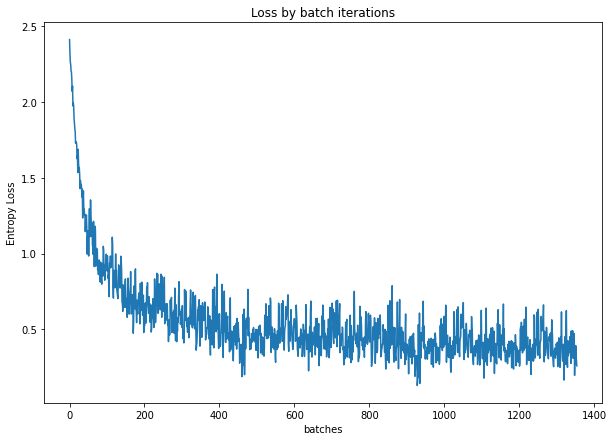

In [18]:
plt.figure(figsize=(10, 7))

plt.plot(history)

plt.title('Loss by batch iterations')
plt.ylabel('Entropy Loss')
plt.xlabel('batches')

plt.show()

Some quality metrics for our linear model

In [19]:
from sklearn.metrics import accuracy_score

In [20]:
acc = 0
batches = 0

for x_batch, y_batch in test_loader:
  # load batches of data correctly
  batches += 1
  x_batch = x_batch.view(x_batch.shape[0], -1)
  y_batch = y_batch

  preds = torch.argmax(x_batch @ W, dim=1)
  acc += (preds==y_batch).cpu().numpy().mean()

print(f'Test accuracy {acc / batches:.3}')

Test accuracy 0.902


Result, we now see that every variable or tensor is provided with its own `grad` and `grad_fn`. This part showed we can directly manipulate with them. Also it is very inconvinient, but sometimes we should be able to access such flexibility.

Of course PyTorch has higher level of operations between weights and grads, than we saw above. Next part introduces high level of modeling and training neural networks. 


## Model

PyTorch is flexible framework to build any kind of neural network

Here is a table of comparison:

```
| API             | Flexibility | Convenience |,
|-----------------|-------------|-------------|,
| Barebone        | High        | Low         |,
| `nn.Module`     | High        | Medium      |,
| `nn.Sequential` | Low         | High        |
```

1. barebone is the approach where we directly manipulate with ternsors. In the example above we had the objective function directly expressid by weights. If we develop this method into classes we would get this level of API. **On this level we code modules by ourselves**

2. [`nn.Module`](https://pytorch.org/docs/stable/nn.html) is the parent class for many PyTorch introduced modules. There are plenty of them. They are pretty enough to use them out-of-the-box with required parameters. Mostly we use:

- `nn.Linear`
- `nn.Softmax`, `nn.LogSoftmax`
- `nn.ReLU`, `nn.ELU`, `nn.LeakyReLU`
- `nn.Tanh`, `nn.Sigmoid`
- `nn.LSTM`, `nn.GRU`
- `nn.Conv1d`, `nn.Conv2d`
- `nn.MaxPool1d`, `nn.AdaptiveMaxPool1d` and others pooling
- `nn.BatchNorm1d`, `nn.BatchNorm2d`
- `nn.Dropout`
- losses: `nn.CrossEntropyLoss`, `nn.NLLLoss`, `nn.MSELoss`
- etc

3. `nn.Sequential` is no more than sequence of different modules based on `nn.Module`. They are initiatiated by a list of modules, where output from one module goes as input for next in sequence.


Let's **develop a simple sequential** to classify MNIST using **two linear layers** model.

In [22]:
import torch.nn as nn
from torchsummary import summary

ModuleNotFoundError: No module named 'torchsummary'

In [23]:
model = nn.Sequential(
  nn.Linear(features, 64),
  nn.ReLU(),
  nn.Linear(64, classes)
)

# It is the same as:
#
# model = nn.Sequential()
# model.add_module('0', nn.Linear(features, 64))
# model.add_module('1', nn.Linear(64, classes))

model.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=10, bias=True)
)

We can check if everything is fine with hidden layers by `torchsummary.summary`. It needs the shape of input data to produce visualisation of model

In [24]:
summary(model, (features,), batch_size=228)

NameError: name 'summary' is not defined

## Train

As we know, most important thing to do in solving problem are **3 things**:

1. Model
2. Objective (loss function)
3. Optimizing (objective w.r.t. model parameters)

Good, everything we must do when using PyTorch is **define these 3 things**:

1. Model: from `nn.Module` API
2. Loss: again, `nn.Module` or [`nn.functional`](https://pytorch.org/docs/stable/nn.functional.html) API
3. Optimizer: based on [`torch.optim.Optimizer`](https://pytorch.org/docs/stable/optim.html)

In the previous tasks when it came to optimize objective we used **direct solution or gradient descent optimizations**

Of course, there are plenty upgrades of gradient descent. It can use **adaptive step value**, **previous step gradients** and others. PyTorch also provides some classes for gradient optimizations. They are initializing with parameters they should tune for better loss value and during descent they do the step in gradient-based descent method.

Here is the most used optimizers, based on which descent algorithm is used:

- `torch.optim.Adam` uses both second and first momentum of gradient, very popular for its speed of convergence, simplicity. [paper](https://arxiv.org/abs/1412.6980)

- `torch.optim.SGD` - good-old stochastic gradient descent. Can be used with Nesterov momentum optimization

- `torch.optim.Adagrad` - [paper](https://jmlr.org/papers/v12/duchi11a.html)

- `torch.optim.RMSprop` - introduced in [slides](https://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf)



First define the last 2 things: criterion and optimizer

In [25]:
criterion = nn.CrossEntropyLoss()      # (logsoftmax + negative likelihood) in its core, applied to logits

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.99))

Finally, we are heading to **train loop**!

Previously we iterated over epochs and batches (this is called train loop). So, let's do it here

In [26]:
epochs = 3
history = []

In [27]:
for i in range(epochs):
  for x_batch, y_batch in train_loader:
    # 1. load batches of data correctly
    x_batch = x_batch.view(x_batch.shape[0], -1).to(device)
    y_batch = y_batch.to(device)

    # 2. compute scores with .forward or .__call__
    logits = model(x_batch)

    # 3. compute loss
    loss = criterion(logits, y_batch)
    history.append(loss.item())

    # 4. calc gradients
    optimizer.zero_grad()
    loss.backward()

    # 5. step of gradient descent
    optimizer.step()

  print(f'{i+1},\t loss: {history[-1]}')

1,	 loss: 0.07550996541976929
2,	 loss: 0.0560729093849659
3,	 loss: 0.03986748680472374


Plot and accurracy just to check the correctness.

In [28]:
import matplotlib.pyplot as plt

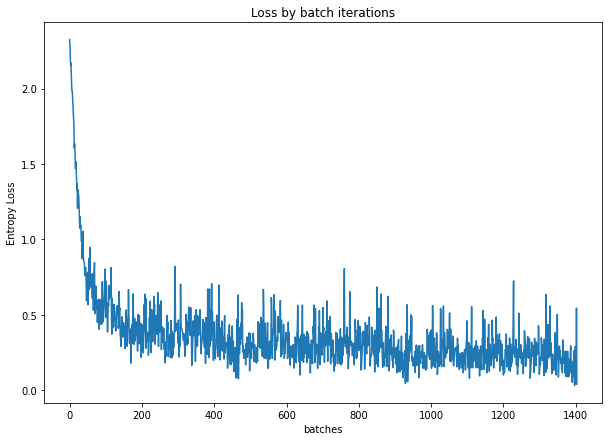

In [29]:
plt.figure(figsize=(10, 7))

plt.plot(history)

plt.title('Loss by batch iterations')
plt.ylabel('Entropy Loss')
plt.xlabel('batches')

plt.show()

Some quality metrics for our two layer model

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
acc = 0
batches = 0

for x_batch, y_batch in test_loader:
  # load batch of data correctly
  batches += 1
  x_batch = x_batch.view(x_batch.shape[0], -1).to(device)
  y_batch = y_batch.to(device)

  preds = torch.argmax(model(x_batch), dim=1)
  acc += (preds==y_batch).cpu().numpy().mean()

print(f'Test accuracy {acc / batches:.3}')

## Summary

We have build and trained the most simple neural network. It has been done by defining:

1. `model`
2. `criterion`
1. `optimizer`

Remember the steps during train on batch:

1. load batch
2. do forward pass of model (get `scores`)
3. calculate `loss` (using criterion over `scores` and true labels of batch)
4. perform `loss.backward()` (compute gradients of loss w.r.t. parameters)
5. do optimization step (`optimizer.step()`)
* zero gradients (place it everywhere but not between 4 and 5)
* validating (after each epoch)

